# Spot-to-Spot Alignment of DLPFC Data Incorporating Histological Images  

In this experiment, we demonstrate **GALA’s multimodal alignment capability** using the **10x Genomics DLPFC dataset**, which provides both **gene expression** and **histological (H&E) image** modalities.  

GALA integrates spatial coordinates, transcriptomic profiles, and histological features within a unified framework to achieve **spot-level multimodal alignment** between adjacent tissue sections. This example highlights how GALA aligns complex spatial transcriptomics data while preserving both molecular and morphological structures.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scanpy as sc
import seaborn as sns
import os
import time
import pickle

import warnings
for cat in [FutureWarning, DeprecationWarning]:
    warnings.filterwarnings("ignore", category=cat)

# data loading path
data_path = os.path.expanduser('./Data/DLPFC')  # Update this path to your data directory  
results_path = os.path.expanduser('./Results')  # Directory to save results

# Load Data  

We use the **preprocessed DLPFC data** provided on [Zenodo](https://zenodo.org/records/6334774), originally hosted by the [Lieber Institute for Brain Development](https://github.com/LieberInstitute/HumanPilot/tree/master/10X).  

**Note:**  
- In this example, we align **slice 3 (source)** to **slice 2 (target)** from **Sample C**.  
- Please ensure that the data path in the code is updated to match your **local directory structure**.

In [2]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {
    sample: sc.read_h5ad(os.path.join(data_path, f"{sample}_preprocessed.h5"))
    for sample in sample_list
}
sample_groups = [["151507", "151508", "151509","151510"], [ "151669", "151670","151671", "151672"], [ "151673","151674", "151675", "151676"]]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

###
### Choose Sample and slices.
### In this tutorial, we choose sample 151674 (slice 2 of Sample C) as target and 151675 (slice 3 of Sample C)  as source.
sample_choose = 2
target = adatas[sample_groups[sample_choose][1]]
source = adatas[sample_groups[sample_choose][2]]
# common genes
shared_gene_names = target.var_names.intersection(source.var_names)
target = target[:,shared_gene_names]
source = source[:,shared_gene_names]


## Visualise Raw Tissue Slices

We plot the raw tissue slices with annotated cortical layers overlaid on their corresponding H&E histological images.

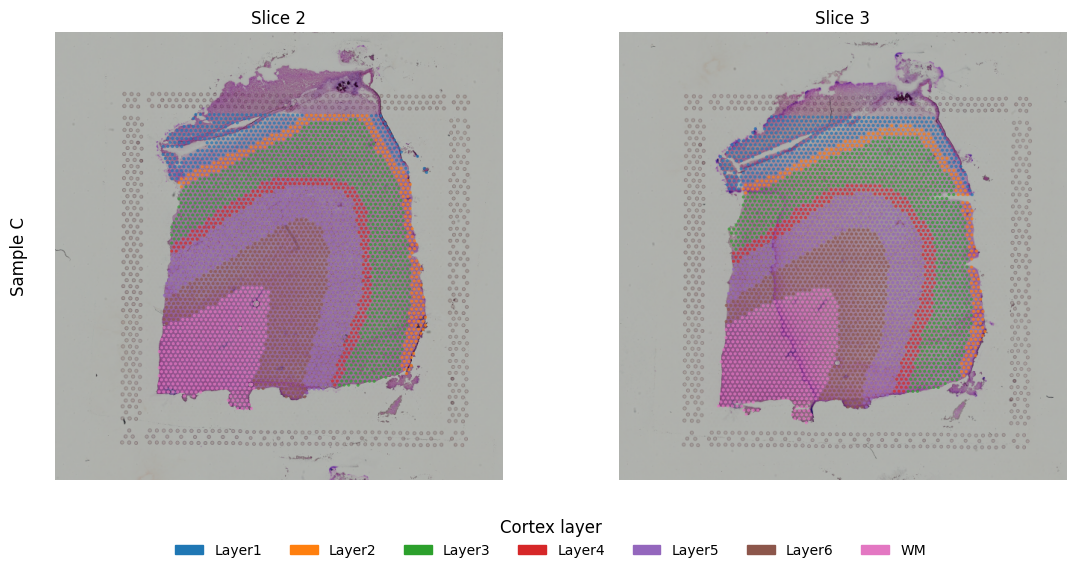

In [3]:
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs[0].text(-0.1, 0.5, 'Sample C', fontsize=12, rotation='vertical',
            transform=axs[0].transAxes, verticalalignment='center')
for i in range(2):
    adata = adatas[sample_groups[sample_choose][i]]
    img = adata.uns['lowres_image']
    colors = list(adata.obs['Ground Truth'].astype('str').map(layer_to_color_map))
    axs[i].imshow(img)
    axs[i].scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
                   linewidth=0, s=20, marker=".", color=colors,alpha = 0.7)
    axs[i].set_title(f'Slice {i+2}', size=12)
    axs[i].axis('off')
# Construct legend handles
categories = adata.obs['Ground Truth'].cat.categories
handles = [mpatches.Patch(color=layer_to_color_map[c], label=c) for c in categories]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5,-0.15),
           ncol=len(categories), fontsize=10, title='Cortex layer', title_fontsize=12,frameon=False)

plt.tight_layout()
plt.show()


# Rasterisation
Following the previous discussion on the selection of top $p$ genes, we set $p = 3$ in the subsequent experiment.

In [4]:
from GALA.utils import top_p_genes
###
### select top p genes
###
p = 3 # Number of predictive genes choosen
top_gene_names = top_p_genes(source, shared_gene_names, p = p)
print(top_gene_names)

Index(['MBP', 'MT-CO1', 'MT-CO3'], dtype='object')


We set the fusion weight between transcriptomic and histological modalities to $\alpha = 0.5$, and the unit length of the raster grid to approximately 1.

In [5]:
from GALA.utils import rasterize_channel, rasterize_image
### Hyper-parameters
alp = 0.5  # Fusion weights of molecular and morphological modalities
scale = target.uns['scale']['tissue_lowres_scalef']

dx = scale*20 # approximate to 1
print(f'Scale of low_res: {scale}; Unit legneth of raster grid: {dx}')
### Expression
# source 
X = np.array(source[:,top_gene_names].X.todense())
xi = source.obsm['spatial'][:,0]
yi = source.obsm['spatial'][:,1]
gi = np.array(source.X.sum(axis=1))
si = np.concatenate([X, gi], axis=1)
XI,YI,I_expr = rasterize_channel(xi, yi, si,dx = dx)
# target
X = np.array(target[:,top_gene_names].X.todense())
xj = target.obsm['spatial'][:,0]
yj = target.obsm['spatial'][:,1]
gj = np.array(target.X.sum(axis = 1))
sj = np.concatenate([X, gj], axis=1)
XJ,YJ,J_expr = rasterize_channel(xj, yj, sj,dx = dx)

### Image
if alp ==1.0:
    I = I_expr
    J = J_expr
else :
    # Source
    imgi = source.uns['lowres_image']
    _,_,I_img = rasterize_image(xi, yi, imgi,dx = dx)
    I_img = I_img[None,...]
    I = np.concatenate([alp*I_expr,(1-alp)*I_img],axis = 0)
    
    # Target
    imgj = target.uns['lowres_image']
    _,_,J_img = rasterize_image(xj, yj, imgj, dx = dx)
    J_img = J_img[None,...]
    J = np.concatenate([alp*J_expr,(1-alp)*J_img],axis = 0)

### Input data
xI = [YI,XI]
xJ = [YJ,XJ] 

Scale of low_res: 0.045004502; Unit legneth of raster grid: 0.90009004
0 of 3566
3565 of 3566
0 of 3635
3634 of 3635
0 of 3566
3565 of 3566
0 of 3635
3634 of 3635


# GALA  
We aligned slice 3 to slice 2 in two episodes, using the default 1000 generations for the GA-based affine search and up to 5000 iterations for the EM-like LDDMM refinement.

In [6]:
from GALA.utils import alignedada,to_cpu
from GALA.gala import gala


# Prior seeting for easier global search in GA. It is optional. However, observing the raw slices, the prior knowledge will enforce the robust performance of GA by reducing the number of parameters.
gene_space=[
        {'low': -45, 'high': 45},   # angle
        {'low': 1.0, 'high': 1.0},  # sy
        {'low': 1.0, 'high': 1.0},  # sx
        {},  # ty
        {}   # tx
    ]

### Parameters in the whole framework
params = {'num_generations' : 1000,
          'num_iterations': 5000,
          'num_repeats': 2,
          'epV': dx,
          'a': dx,
          'sigmaR':1000,
          'sigmaM': I.std(),
          'sigmaB': J.std(),
          'random_seed': 42
          }
start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 
### copy results from GPU to CPU 
if torch.cuda.is_available():
    resu = to_cpu(resu)

# with open(os.path.join(results_path, "resu_slice3_to_2_SampleC.pkl"), 'wb') as f:
#     pickle.dump(resu, f)

Iteration 1 of 2
Generation = 200
Fitness    = 0.0009609348632745049
Change     = 0.0009609348632745049
Generation = 400
Fitness    = 0.0009615303966436893
Change     = 5.955333691843668e-07
Generation = 600
Fitness    = 0.0009623287463526321
Change     = 7.983497089427815e-07
Generation = 800
Fitness    = 0.0009632683450253333
Change     = 9.39598672701188e-07
Generation = 1000
Fitness    = 0.0009637495568553399
Change     = 4.812118300066446e-07
Best transformation: angle=-0.02, sx=1.00, sy=1.00, tx=-9.77, ty=-13.57
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
4999 of 5000
Iteration 2 of 2
Generation = 200
Fitness    = 0.0009609348632745049
Change     = -2.814693580834981e-06
Generation = 400
Fitness    = 0.0009615303966436893
Change     = 5.955333691843668e-07
Generation = 600
Fitness    = 0.0009623287463526321
Change     = 7.983497089427815e-07
Generation = 800
Fitness    = 0.0009632683450253333
Change

# Result Analysis
Load results

In [7]:
with open(os.path.join(results_path, "resu_slice3_to_2_SampleC.pkl"), 'rb') as f:
   resu = pickle.load(f)

## Energy Function

Enery value before alignment: 94205.05679976894; Enery value after alignment: 65359.91403105059


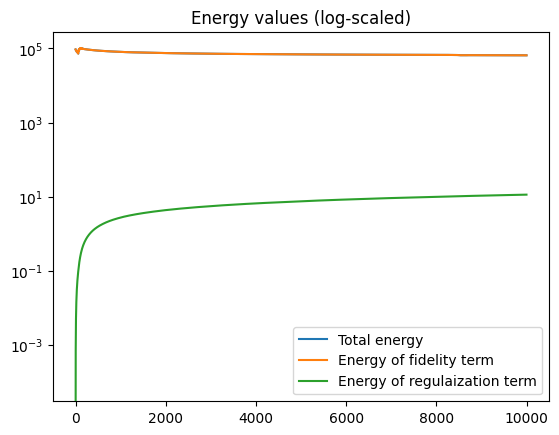

In [8]:
### Convergence of enery function 
E = resu['E']
print(f'Enery value before alignment: {E[0][0]}; Enery value after alignment: {E[-1][0]}')

fig, ax = plt.subplots()
ax.plot(E)
ax.legend(['Total energy','Energy of fidelity term','Energy of regulaization term'])
ax.set_yscale('log')
ax.set_title('Energy values (log-scaled)')
plt.show()

## Visualization of Alignment Components  
We first compute and display the **mean matching probability** \(W_M\), followed by a visualisation of the full **matching probability matrix** to assess how well the source and target slices correspond.

Matching probabilities: tensor([0.9982, 0.0018])


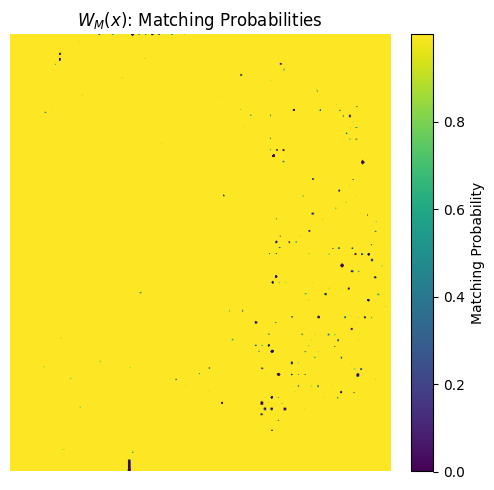

In [9]:
from GALA.utils import build_transform, transform_image_source_to_target
### Matching and Background Probabilities
WM = resu['WM'].cpu()
WB = resu['WB'].cpu()

W = torch.stack((WM,WB))
pi = torch.sum(W,dim=(1,2))
pi += torch.max(pi)*1e-6
pi /= torch.sum(pi)
print('Matching probabilities:', pi)

fig,ax = plt.subplots(figsize = (6,5))
im = ax.imshow(WM)
ax.set_title(r'$W_M(x)$: Matching Probabilities')
ax.axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Matching Probability')  

plt.tight_layout()
plt.show()

Next, we visualise the  **diffeomorphic mapping** \(\phi^v(A(x))\).  
To better illustrate the mapping effect, the transformed rasterized image of total gene expression is plotted as the background, showing how source features are deformed to match the target.

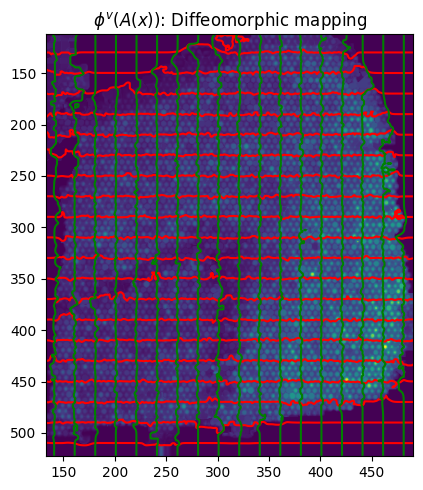

In [10]:
### Phi:  from source to target
xv = resu['xv']
v = resu['v']
A = resu['A']
device = 'cpu'
xI = [YI,XI]
xJ = [YJ,XJ]
xI = [torch.as_tensor(x,device = 'cpu') for x in xI]
xJ = [torch.as_tensor(x,device = 'cpu') for x in xJ]
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

### Forward
phii = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
aI = I[3]
aI = aI[None,...]
phiI = transform_image_source_to_target(xv,v,A,xI,aI,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
extentJ = extent_from_x((YJ,XJ))

### plot
fig,ax = plt.subplots(figsize=(6, 5))
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels= np.arange( phii.min(), phii.max(), 20)  )
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels= np.arange( phii.min(), phii.max(), 20))
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent = extentJ)
ax.set_title(r'$\phi^v(A(x))$: Diffeomorphic mapping')
#ax[1].axis('off')

plt.tight_layout()
plt.show()


## Aligned Slices

Finally, we visualise the **source and target slices before and after alignment**.  

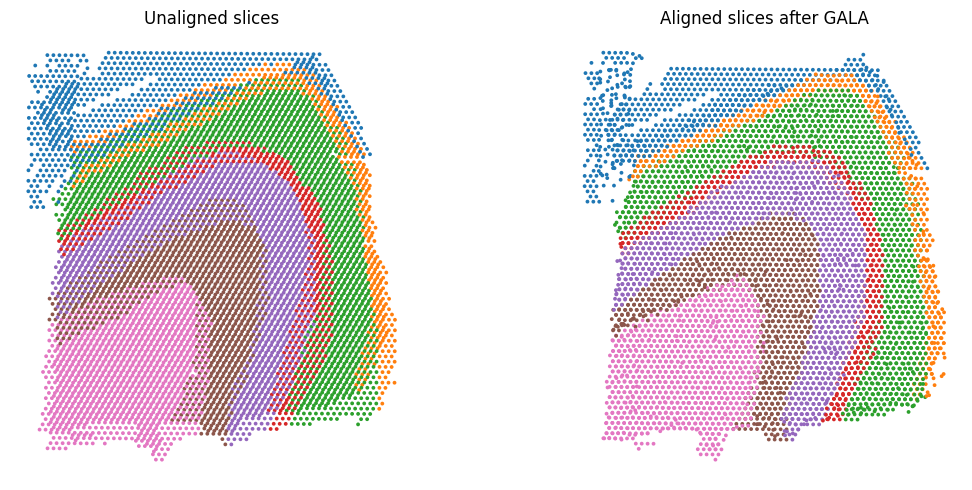

In [11]:
from GALA.utils import alignedada

fs = 30
# Aligned slice by GALA
aligned_source = alignedada(resu, source)
aligned_source.obsm = {'spatial': aligned_source.obsm['aligned'].copy()}

fig, ax = plt.subplots(1,2, figsize=(12,5))
colors_t = list(target.obs['Ground Truth'].astype('str').map(layer_to_color_map))
colors_s = list(aligned_source.obs['Ground Truth'].astype('str').map(layer_to_color_map))
### Unaligned slices    
ax[0].scatter(target.obsm['spatial'][:, 0], target.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_t)
ax[0].scatter(source.obsm['spatial'][:, 0], source.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_s)
ax[0].set_title('Unaligned slices', size=12)
ax[0].axis('off')
ax[0].invert_yaxis()
ax[0].set_aspect('equal')

### gala
ax[1].scatter(target.obsm['spatial'][:, 0], target.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_t)
ax[1].scatter(aligned_source.obsm['spatial'][:, 0], aligned_source.obsm['spatial'][:, 1],linewidth=0, s=fs, marker=".", color=colors_s)
ax[1].set_title('Aligned slices after GALA', size=12)
ax[1].axis('off')
ax[1].invert_yaxis()
ax[1].set_aspect('equal')

plt.tight_layout()
plt.show()



## 3D Reconstruction

We load the **aligned slices 2, 3, and 4** and register them relative to **reference slice 1**.  
This step prepares the data for constructing a **3D spatial reconstruction** of the tissue while preserving the alignment of multimodal information across slices.

In [12]:
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
def load_aligned_slice(pkl_name, source):
    with open(os.path.join(results_path, pkl_name), 'rb') as f:
        resu = pickle.load(f)
    aligned_source = alignedada(resu, source)
    aligned_source.obsm = {'spatial': aligned_source.obsm['aligned'].copy()}
    return aligned_source

def slice_stack_3d(coords,layer_groups,sample_choose):
    stacked_slices = [[], [], [],[]]
    for j, L in enumerate(coords):
        for x, y in L:
            stacked_slices[0].append(x)
            stacked_slices[1].append(y)
            stacked_slices[2].append(j)
        list = layer_groups[sample_choose][j].obs['Ground Truth'].tolist()
        for label in list:
            stacked_slices[3].append(label)
    return(stacked_slices)
# 
slice1 = adatas[sample_groups[sample_choose][0]]
slice2 = load_aligned_slice("resu_slice2_to_1_SampleC.pkl", adatas[sample_groups[sample_choose][1]])
slice3 = load_aligned_slice("resu_slice3_to_1_SampleC.pkl", adatas[sample_groups[sample_choose][2]])
slice4 = load_aligned_slice("resu_slice4_to_1_SampleC.pkl", adatas[sample_groups[sample_choose][3]])

coords_slice1 = slice1.obsm['spatial']
coords_slice2 = slice2.obsm['spatial']
coords_slice3 = slice3.obsm['spatial']
coords_slice4 = slice4.obsm['spatial']
coords = [coords_slice1, coords_slice2, coords_slice3, coords_slice4]
lists_3d = slice_stack_3d(coords,layer_groups,sample_choose=sample_choose)

Plot 3D reconstruction of Sample C by GALA

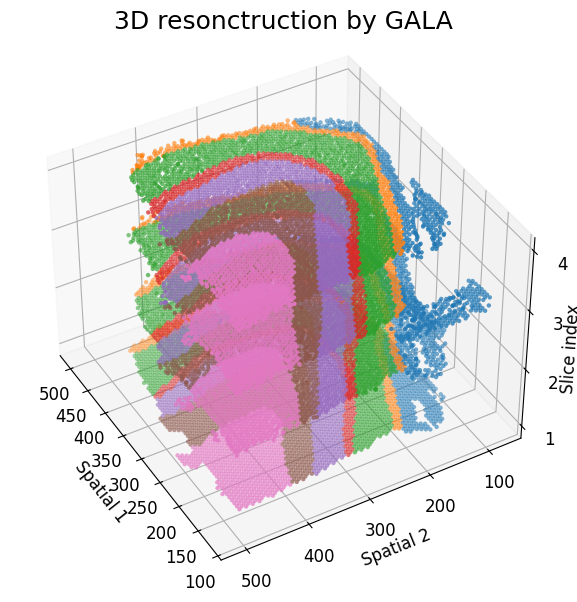

In [13]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')  

ax.scatter(lists_3d[0], lists_3d[1], lists_3d[2], c=[layer_to_color_map[j] for j in lists_3d[3]],linewidth=0, s=40, marker=".")
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='z', labelsize=12)

ax.set_zlabel('Slice index',fontsize = 12, labelpad=-3)
ax.set_zticks([0, 1, 2, 3])               
ax.set_zticklabels(['1', '2', '3', '4'])  

ax.set_xlabel('Spatial 1',fontsize = 12)
ax.set_ylabel('Spatial 2',fontsize = 12)
ax.set_title(' 3D resonctruction by GALA', fontsize = 18)
ax.view_init(elev=40, azim=150)


plt.show()

Alternatively, we can further investigate 3D reconstruction by interactive 3D reconstruction output, here.

In [14]:
import plotly.graph_objs as go
import plotly.offline as pyo

# load saved results
slice_list = [
    ("slice1", adatas[sample_groups[sample_choose][0]]),
    ("slice2", slice2),
    ("slice3", slice3),
    ("slice4", slice4)
]

fig = go.Figure()
all_layers = set()
for _, adata in slice_list:
    all_layers.update(adata.obs['Ground Truth'].astype(str).unique())

for layer in sorted(all_layers):
    for z_index, (label, adata) in enumerate(slice_list):
        coords = adata.obsm["spatial"]
        ground_truth = adata.obs['Ground Truth'].astype(str)

        mask = ground_truth == layer
        if mask.sum() == 0:
            continue

        sub_coords = coords[mask]
        z = np.full(sub_coords.shape[0], z_index)

        # map colors based on the layer
        mapped_colors = ground_truth.map(layer_to_color_map)
        sub_colors = mapped_colors[mask].values  # hex

        fig.add_trace(go.Scatter3d(
            x=sub_coords[:, 0],
            y=sub_coords[:, 1],
            z=z,
            mode='markers',
            marker=dict(size=1.5, color=sub_colors, opacity=0.7),
            name=f'{layer}',
            legendgroup=layer,
            showlegend=(z_index == 0),
            text=[f'Slice: {label}, Layer: {layer}'] * sub_coords.shape[0]
        ))

# plotly layout settings
fig.update_layout(
    scene=dict(
        xaxis_title='Spatial 1',
        yaxis_title='Spatial 2',
        zaxis_title='Slice index'
    ),
    title='3D Reconstruction',
    legend=dict(
        title='Ground Truth Layer',
        itemsizing='constant',  
        font=dict(size=12),
        itemclick='toggle',    
        itemdoubleclick='toggleothers'
    )
)

pyo.init_notebook_mode(connected=True)  
fig.show()  

